In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## value class implimentation

In [22]:
# start
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #beacuse it uses +=
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self._label = label
        
    def __repr__(self):
        return f"value({self._label} data={self.data})"
    
    def __add__(self, other): #called when we add two value objects
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other): #called when we add two value objects
        out = Value(self.data * other.data, (self, other),'*')
        
        def _backward():
            # += because if we have double variable of same value or we have doulbe connection
            # then we have to add the grad of both e.g if we have 2 time a then derivative of
            # 2a w.r.t a is 2 so we have to add 1+1
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,))
        out._op = 'tanh(x)'
        
        def _backward():
            self.grad +=(1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        o.grad = 1.0
        # topologicl short
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        # backpropagation
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


## helper function

In [23]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

def print_tree(node, level=0, edges=None,):
    if edges is None:
        nodes, edges = trace(node)
    prefix = node._label
    print(" " * (level * 15) + prefix + f" {('('+node._op +')') if node._op else '()'} ---> " + f"(D:{node.data:.4f})  (G:{node.grad:.4f})",end='\n\n')
    state = 0
    for n1, n2 in edges:
        if n2 == node:
            if not state:
                state += 1
                print_tree(n1, level+1,edges)
            else:
                print_tree(n1, level+1,edges)

## main function

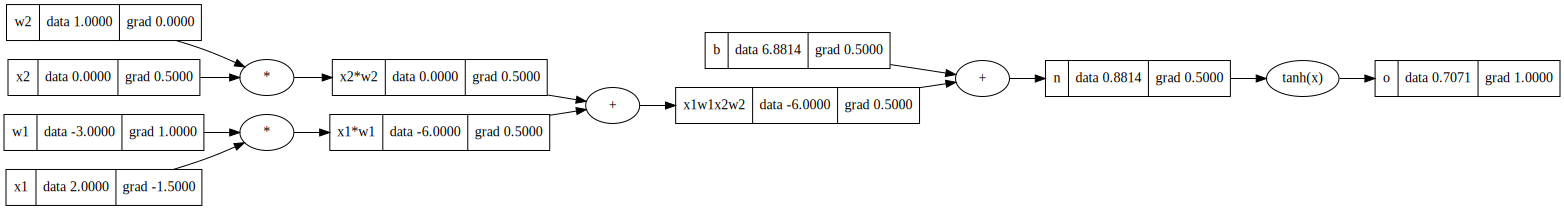

In [24]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'
o.grad = 1.0

# backprop
o.backward()
draw_dot(o)

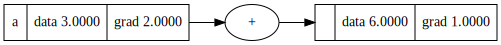

In [25]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)
# print_tree(b,0)

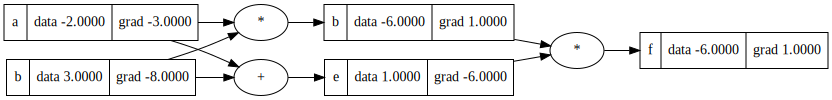

In [29]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d._label = 'b'
e = a + b; e._label = 'e'
f = d * e; f._label = 'f'
f.backward()
draw_dot(f)


In [30]:
print_tree(f,0)

f (*) ---> (D:-6.0000)  (G:1.0000)

               b (*) ---> (D:-6.0000)  (G:1.0000)

                              b () ---> (D:3.0000)  (G:-8.0000)

                              a () ---> (D:-2.0000)  (G:-3.0000)

               e (+) ---> (D:1.0000)  (G:-6.0000)

                              a () ---> (D:-2.0000)  (G:-3.0000)

                              b () ---> (D:3.0000)  (G:-8.0000)

